In [1]:
import torch
from torch import nn
import time
import torchtext
import numpy as np

import random

from collections import defaultdict, Counter

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

import pandas as pd

In [2]:
embvec = torchtext.vocab.GloVe(name='840B', dim=300,cache='/home/pding/Documents/glove/')

In [3]:
import spacy
import en_core_web_sm
svoc = spacy.load("en_core_web_sm")

In [4]:
datao = pd.read_pickle("~/OneDrive/kph/processed2.pkl")
datatrain = datao[datao['ext perc']>=3]
datatest = datao[datao['ext perc']<3]
# separate train and validate 
VAL_RATIO = 0.2
dtrain = datatrain.loc[:,['SRC','TRG']]
dtraink = datatrain.loc[:,['SRC','TRG','keywords','ext perc']]
seed=250
idx = np.arange(datatrain.shape[0])
np.random.seed(seed)
np.random.shuffle(idx)
val_size = int(len(idx) * VAL_RATIO)
df_train = dtrain.iloc[idx[val_size:], :]
df_val = dtrain.iloc[idx[:val_size], :]
df_val_k = dtraink.iloc[idx[:val_size], :]
df_test = datatest.loc[:,['SRC','TRG']]

In [5]:
tokenizertrg = lambda x: x.split()
def tokenizersrc(text): # create a tokenizer function
    return [tok.text for tok in svoc.tokenizer(text)]

In [6]:
def read_data(df_train, datafields):
    examples = []
    words = []
    labels = []
    for pmid in df_train.index:
        words = tokenizersrc(df_train.loc[pmid,'SRC'])
        labels = tokenizertrg(df_train.loc[pmid,'TRG'])
        examples.append(torchtext.data.Example.fromlist([words, labels], datafields))
    return torchtext.data.Dataset(examples, datafields)

In [7]:
class RNNTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        # Embedding layer. If we're using pre-trained embeddings, copy them
        # into our embedding module.
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        # RNN layer. We're using a bidirectional GRU with one layer.
        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        # Output layer. As in the example last week, the input will be two times
        # the RNN size since we are using a bidirectional RNN.
        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        # To deal with the padding positions later, we need to know the
        # encoding of the padding dummy word and the corresponding dummy output tag.
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        # Loss function that we will use during training.
        self.loss = torch.nn.CrossEntropyLoss(reduction='sum')
        
    def compute_outputs(self, sentences):
        # The words in the documents are encoded as integers. The shape of the documents
        # tensor is (max_len, n_docs), where n_docs is the number of documents in this batch,
        # and max_len is the maximal length of a document in the batch.

        # First look up the embeddings for all the words in the documents.
        # The shape is now (max_len, n_sentences, emb_dim).        
        embedded = self.embedding(sentences)

        # Apply the RNN.
        # The shape of the RNN output tensor is (max_len, n_sentences, 2*rnn_size).
        rnn_out, _ = self.rnn(embedded)
        
        # Apply the linear output layer.
        # The shape of the output tensor is (max_len, n_sentences, n_labels).
        out = self.top_layer(rnn_out)
        
        # Find the positions where the token is a dummy padding token.
        pad_mask = (sentences == self.pad_word_id).float()

        # For these positions, we add some large number in the column corresponding
        # to the dummy padding label.
        out[:, :, self.pad_label_id] += pad_mask*10000

        return out
                
    def forward(self, sentences, labels):
        # As discussed above, this method first computes the predictions, and then
        # the loss function.
        
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores = self.compute_outputs(sentences)
        
        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        scores = scores.view(-1, self.n_labels)
        labels = labels.view(-1)
        return self.loss(scores, labels)

    def predict(self, sentences):
        # Compute the outputs from the linear units.
        scores = self.compute_outputs(sentences)

        # Select the top-scoring labels. The shape is now (max_len, n_sentences).
        predicted = scores.argmax(dim=2)

        # We transpose the prediction to (n_sentences, max_len), and convert it
        # to a NumPy matrix.
        return predicted.t().cpu().numpy()

from torchcrf import CRF

class RNNCRFTagger(nn.Module):
    
    def __init__(self, text_field, label_field, emb_dim, rnn_size, update_pretrained=False):
        super().__init__()
        
        voc_size = len(text_field.vocab)
        self.n_labels = len(label_field.vocab)       
        
        self.embedding = nn.Embedding(voc_size, emb_dim)
        if text_field.vocab.vectors is not None:
            self.embedding.weight = torch.nn.Parameter(text_field.vocab.vectors, 
                                                       requires_grad=update_pretrained)

        self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=rnn_size, 
                          bidirectional=True, num_layers=1)

        self.top_layer = nn.Linear(2*rnn_size, self.n_labels)
 
        self.pad_word_id = text_field.vocab.stoi[text_field.pad_token]
        self.pad_label_id = label_field.vocab.stoi[label_field.pad_token]
    
        self.crf = CRF(self.n_labels)
        
    def compute_outputs(self, sentences):
        embedded = self.embedding(sentences)
        rnn_out, _ = self.rnn(embedded)
        out = self.top_layer(rnn_out)
        
        pad_mask = (sentences == self.pad_word_id).float()
        out[:, :, self.pad_label_id] += pad_mask*10000
        
        return out
                
    def forward(self, sentences, labels):
        # Compute the outputs of the lower layers, which will be used as emission
        # scores for the CRF.
        scores = self.compute_outputs(sentences)

        # We return the loss value. The CRF returns the log likelihood, but we return 
        # the *negative* log likelihood as the loss value.            
        # PyTorch's optimizers *minimize* the loss, while we want to *maximize* the
        # log likelihood.
        return -self.crf(scores, labels)
            
    def predict(self, sentences):
        # Compute the emission scores, as above.
        scores = self.compute_outputs(sentences)

        # Apply the Viterbi algorithm to get the predictions. This implementation returns
        # the result as a list of lists (not a tensor), corresponding to a matrix
        # of shape (n_sentences, max_len).
        return self.crf.decode(scores)
# Convert a list of BIO labels, coded as integers, into spans identified by a beginning, an end, and a label.
# To allow easy comparison later, we store them in a dictionary indexed by the start position.
def to_spans(l_ids, voc):
    spans = {}
    current_lbl = None
    current_start = None
    for i, l_id in enumerate(l_ids):
        l = voc[l_id]

        if l[0] == 'B': 
            # Beginning of a named entity: B-something.
            if current_lbl:
                # If we're working on an entity, close it.
                spans[current_start] = (current_lbl, i)
            # Create a new entity that starts here.
            current_lbl = l[2:]
            current_start = i
        elif l[0] == 'I':
            # Continuation of an entity: I-something.
            if current_lbl:
                # If we have an open entity, but its label does not
                # correspond to the predicted I-tag, then we close
                # the open entity and create a new one.
                if current_lbl != l[2:]:
                    spans[current_start] = (current_lbl, i)
                    current_lbl = l[2:]
                    current_start = i
            else:
                # If we don't have an open entity but predict an I tag,
                # we create a new entity starting here even though we're
                # not following the format strictly.
                current_lbl = l[2:]
                current_start = i
        else:
            # Outside: O.
            if current_lbl:
                # If we have an open entity, we close it.
                spans[current_start] = (current_lbl, i)
                current_lbl = None
                current_start = None
    return spans

# Compares two sets of spans and records the results for future aggregation.
def compare(gold, pred, stats):
    for start, (lbl, end) in gold.items():
        stats['total']['gold'] += 1
        stats[lbl]['gold'] += 1
    for start, (lbl, end) in pred.items():
        stats['total']['pred'] += 1
        stats[lbl]['pred'] += 1
    for start, (glbl, gend) in gold.items():
        if start in pred:
            plbl, pend = pred[start]
            if glbl == plbl and gend == pend:
                stats['total']['corr'] += 1
                stats[glbl]['corr'] += 1

# This function combines the auxiliary functions we defined above.
def evaluate_iob(predicted, gold, label_field, stats):
    # The gold-standard labels are assumed to be an integer tensor of shape
    # (max_len, n_sentences), as returned by torchtext.
    gold_cpu = gold.t().cpu().numpy()
    gold_cpu = list(gold_cpu.reshape(-1))

    # The predicted labels assume the format produced by pytorch-crf, so we
    # assume that they have been converted into a list already.
    # We just flatten the list.
    pred_cpu = [l for sen in predicted for l in sen]
    
    # Compute spans for the gold standard and prediction.
    gold_spans = to_spans(gold_cpu, label_field.vocab.itos)
    pred_spans = to_spans(pred_cpu, label_field.vocab.itos)

    # Finally, update the counts for correct, predicted and gold-standard spans.
    compare(gold_spans, pred_spans, stats)

# Computes precision, recall and F-score, given a dictionary that contains
# the counts of correct, predicted and gold-standard items.
def prf(stats):
    if stats['pred'] == 0:
        return 0, 0, 0
    p = stats['corr']/stats['pred']
    r = stats['corr']/stats['gold']
    if p > 0 and r > 0:
        f = 2*p*r/(p+r)
    else:
        f = 0
    return p, r, f

In [8]:
TEXT = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, lower=False)
LABEL = torchtext.data.Field(init_token='<bos>', eos_token='<eos>', sequential=True, unk_token=None)
fields = [('text', TEXT), ('label', LABEL)]
device = 'cuda'
use_pretrained = True

In [9]:
train_examples = read_data(df_train, fields)
valid_examples = read_data(df_val, fields)
# Load the pre-trained embeddings that come with the torchtext library.
if use_pretrained:
    print('We are using pre-trained word embeddings.')
    TEXT.build_vocab(train_examples, vectors=embvec)
else:  
    print('We are training word embeddings from scratch.')
    TEXT.build_vocab(train_examples, max_size=5000)
LABEL.build_vocab(train_examples)
# Create one of the models defined above.
#self.model = RNNTagger(self.TEXT, self.LABEL, emb_dim=300, rnn_size=128, update_pretrained=False)
model0 = RNNTagger(TEXT, LABEL, emb_dim=300, rnn_size=100, update_pretrained=False)

model0.to(device)

We are using pre-trained word embeddings.


RNNTagger(
  (embedding): Embedding(72288, 300)
  (rnn): LSTM(300, 100, bidirectional=True)
  (top_layer): Linear(in_features=200, out_features=6, bias=True)
  (loss): CrossEntropyLoss()
)

In [10]:
batch_size = 310

optimizer = torch.optim.Adam(model0.parameters(), lr=0.01, weight_decay=1e-5)

n_epochs = 15

In [11]:
def train(train_examples, valid_examples, embvec, TEXT, LABEL, device, model, batch_size, optimizer, n_epochs):


    # Count the number of words and sentences.
    n_tokens_train = 0
    n_sentences_train = 0
    for ex in train_examples:
        n_tokens_train += len(ex.text) + 2
        n_sentences_train += 1
    n_tokens_valid = 0       
    for ex in valid_examples:
        n_tokens_valid += len(ex.text)


    
    n_batches = np.ceil(n_sentences_train / batch_size)

    mean_n_tokens = n_tokens_train / n_batches

    train_iterator = torchtext.data.BucketIterator(
        train_examples,
        device=device,
        batch_size=batch_size,
        sort_key=lambda x: len(x.text),
        repeat=False,
        train=True,
        sort=True)

    valid_iterator = torchtext.data.BucketIterator(
        valid_examples,
        device=device,
        batch_size=64,
        sort_key=lambda x: len(x.text),
        repeat=False,
        train=False,
        sort=True)

    train_batches = list(train_iterator)
    valid_batches = list(valid_iterator)

    n_labels = len(LABEL.vocab)

    history = defaultdict(list)    

   

    for i in range(1, n_epochs + 1):

        t0 = time.time()

        loss_sum = 0

        model.train()
        for batch in train_batches:

            # Compute the output and loss.
            loss = model(batch.text, batch.label) / mean_n_tokens

            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        train_loss = loss_sum / n_batches
        history['train_loss'].append(train_loss)

        # Evaluate on the validation set.
        if i % 1 == 0:
            stats = defaultdict(Counter)

            model.eval()
            with torch.no_grad():
                for batch in valid_batches:
                    # Predict the model's output on a batch.
                    predicted = model.predict(batch.text)                   
                    # Update the evaluation statistics.
                    evaluate_iob(predicted, batch.label, LABEL, stats)

            # Compute the overall F-score for the validation set.
            _, _, val_f1 = prf(stats['total'])

            history['val_f1'].append(val_f1)

            t1 = time.time()
            print(f'Epoch {i}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')

    # After the final evaluation, we print more detailed evaluation statistics, including
    # precision, recall, and F-scores for the different types of named entities.
    print()
    print('Final evaluation on the validation set:')
    p, r, f1 = prf(stats['total'])
    print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
    for label in stats:
        if label != 'total':
            p, r, f1 = prf(stats[label])
            print(f'{label:4s}: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')

    plt.plot(history['train_loss'])
    plt.plot(history['val_f1'])
    plt.legend(['training loss', 'validation F-score'])


Epoch 1: train loss = 0.2127, val f1: 0.0000, time = 3.0741
Epoch 2: train loss = 0.1482, val f1: 0.0000, time = 2.9418
Epoch 3: train loss = 0.1359, val f1: 0.0000, time = 2.8501
Epoch 4: train loss = 0.1304, val f1: 0.0000, time = 2.8539
Epoch 5: train loss = 0.1271, val f1: 0.0000, time = 2.8531
Epoch 6: train loss = 0.1249, val f1: 0.0000, time = 2.9543
Epoch 7: train loss = 0.1230, val f1: 0.0000, time = 2.8456
Epoch 8: train loss = 0.1213, val f1: 0.0000, time = 2.8515
Epoch 9: train loss = 0.1200, val f1: 0.0000, time = 2.9355
Epoch 10: train loss = 0.1185, val f1: 0.0000, time = 2.8671
Epoch 11: train loss = 0.1181, val f1: 0.0000, time = 2.8741
Epoch 12: train loss = 0.1176, val f1: 0.0000, time = 2.9343
Epoch 13: train loss = 0.1168, val f1: 0.0000, time = 2.8603
Epoch 14: train loss = 0.1171, val f1: 0.0000, time = 2.8632
Epoch 15: train loss = 0.1163, val f1: 0.0000, time = 2.8766

Final evaluation on the validation set:
Overall: P = 0.0000, R = 0.0000, F1 = 0.0000


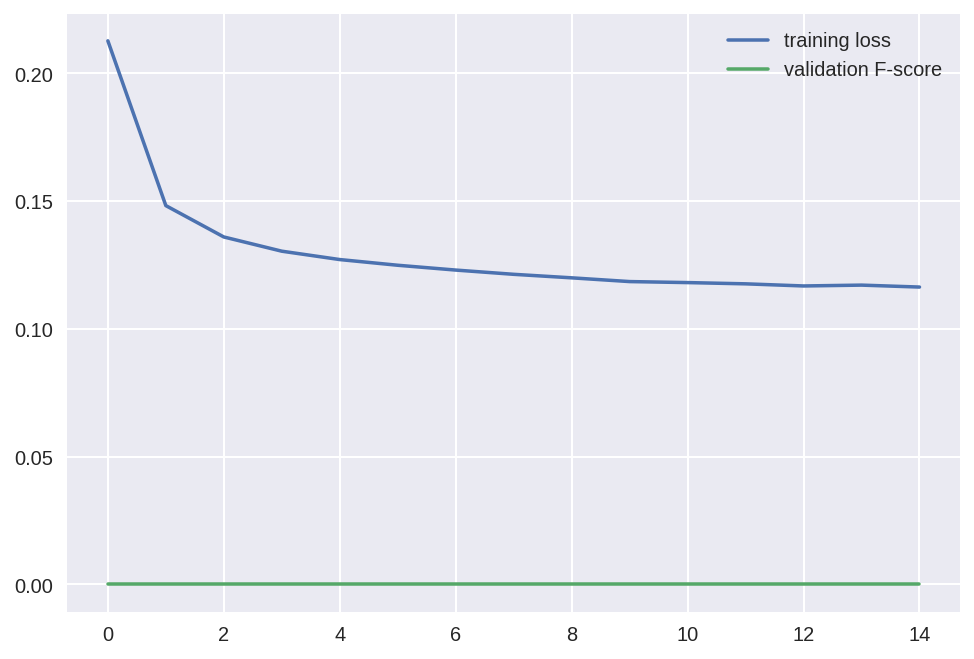

In [12]:
train(train_examples, valid_examples, embvec, TEXT, LABEL, device, model0, batch_size, optimizer,n_epochs)

In [17]:
torch.save(model0.state_dict(), '/home/pding/OneDrive/kph/kph/lstmcrflow.pt')

In [ ]:
torch.save(model0.state_dict(), '/home/pding/OneDrive/kph/kph/lstm100.pt')

In [63]:
model0.load_state_dict(torch.load('/home/pding/OneDrive/kph/kph/lstmcrf.pt'))

RuntimeError: Error(s) in loading state_dict for RNNCRFTagger:
	size mismatch for rnn.weight_ih_l0: copying a param with shape torch.Size([384, 300]) from checkpoint, the shape in current model is torch.Size([512, 300]).
	size mismatch for rnn.weight_hh_l0: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for rnn.bias_ih_l0: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for rnn.bias_hh_l0: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for rnn.weight_ih_l0_reverse: copying a param with shape torch.Size([384, 300]) from checkpoint, the shape in current model is torch.Size([512, 300]).
	size mismatch for rnn.weight_hh_l0_reverse: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([512, 128]).
	size mismatch for rnn.bias_ih_l0_reverse: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for rnn.bias_hh_l0_reverse: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([512]).

In [13]:
def kphext2(sentences,tags):
    kph = []
    for i in range(len(sentences)):
        s0 = svoc.tokenizer(sentences[i])
        s1 = [tok.text for tok in s0]
        t1 = tags[i]
        k1 = []
        for j in range(len(s1)):
            start = j
            if t1[j] == 'B':
                sti = 0
                stop = j+1
                while sti == 0:
                    try: 
                        kt = str(t1[stop])
                        if kt == 'I':
                            stop = stop+1
                        else:
                            k2 = str(s0[start:stop])
                            k1.append(k2)
                            sti =1
                    except(IndexError):
                        k2 = s0[start:stop]
                        k1.append(k2)
                        sti =1
                k2 = str(s1[j])
        kph.append(k1)
    return kph

In [14]:
def evaltest2(df_val, df_val_k, model):
    # This method applies the trained model to a list of sentences.
    examples = []
    for sen in df_val.SRC:
        words = tokenizersrc(sen)
        labels = ['O']*len(words) # placeholder
        examples.append(torchtext.data.Example.fromlist([words, labels], fields))
    dataset = torchtext.data.Dataset(examples, fields)

    iterator = torchtext.data.Iterator(
        dataset,
        device=device,
        batch_size=1,
        repeat=False,
        train=False,
        sort=False)

    # Apply the trained model to all batches.
    out = []
    model.eval()
    for batch in iterator:
        # Call the model's predict method. This returns a list of NumPy matrix
        # containing the integer-encoded tags for each sentence.
        predicted = model.predict(batch.text)

        # Convert the integer-encoded tags to tag strings.
        #for tokens, pred_sen in zip(sentences, predicted):
        for tokens, pred_sen in zip(batch.text.view(1,-1), predicted):
            out.append([LABEL.vocab.itos[pred_id] for _, pred_id in zip(tokens, pred_sen[1:])])
    return out

In [155]:
out1 = evaltest(valid_examples, df_val_k, model0)

In [15]:
out2 = evaltest2(df_val, df_val_k, model0)

In [17]:
def tokperct(df_val,out):
    tp = np.empty(len(out))
    for i in range(len(df_val.index)):
        trg = tokenizertrg(df_val.iloc[i,1])
        total = 0
        for x in trg:
            total = total+1
        matched = 0
        for j in range(total):
            if trg[j]== out[i][j]:
                matched = matched +1
        p = matched/total
        tp[i] = p
    return tp
        

In [18]:
def tagperct(df_val,out):
    tp = np.empty(len(out))
    for i in range(len(df_val.index)):
        trg = tokenizertrg(df_val.iloc[i,1])
        total = 0
        for x in trg:
            if x != 'O':
                total = total+1
        matched = 0
        for j in range(total):
            if trg[j] != 'O':
                if trg[j]== out[i][j]:
                    matched = matched +1
        p = matched/total
        tp[i] = p
    return tp
        

In [19]:
def kphperct(df_val_k,out):
    tp = np.empty(len(out))
    for i in range(len(df_val_k.index)):
        ktrg = df_val_k.iloc[i,2]
        pred = kphext2([df_val_k.iloc[i,0]],[out[i]])
        k = 0
        for kp in ktrg:
            if str(kp).lower() in [str(x).lower() for x in pred[0]]:
                k = k+1
        #tp[i] = k/len(ktrg)
        tp[i] = k/df_val_k.iloc[i,3]
    return tp

In [20]:
ttp1= tokperct(df_val,out2)

In [21]:
ttp1.mean()

0.9423427081532538

In [22]:
ttp2 = tagperct(df_val,out2)

In [23]:
ttp2.mean()

0.14980418735061668

In [24]:
ttp3 = kphperct(df_val_k,out2)

In [25]:
ttp3.mean()

0.4887058797049621

In [397]:
import pickle
pickle.dump( out2, open( "/home/pding/OneDrive/kph/kph/testresults.p", "wb" ) )

In [388]:
ttp3.mean()

0.3915932524942566

In [378]:
ttp3.mean()

0.024907155236444666

In [330]:
for x in trg:
    if x != 'O':
        total = total+1


In [331]:
total

10

In [349]:
df_val.iloc[1,1].

'B O O B O O O O O O O O O O B B O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O B O O B B O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B B O O O O O O O O O O O O O O O O O O O O O O O O B O O B O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

In [401]:
x = 'True'

In [402]:
x is True

False